In [1]:
from UTILITY_quickstart import *

In [2]:
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_twoIslandStudy.yml")
importedDefaultSettings = loadConfig("setLattice_configs/2025-06-17_twoBunch_forMuons_6GeV.yml")

In [3]:
csrTF = False
evalElement = "PENT"



inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
bunchCount = importedDefaultSettings["bunchCount"]
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e4,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_11726950308280606623.h5, and reinit to tao


In [4]:
getMatrix(tao, "BEGBC20", "MFFF", print = True);

-1.217489,-4.973529,-0.000000,-0.000000,0.000000,0.000655
-0.088914,-1.184581,0.000000,0.000000,0.000000,0.000025
-0.000000,-0.000000,-0.616696,6.832510,0.000000,-0.000000
-0.000000,-0.000000,-0.093776,-0.582575,0.000000,-0.000000
-0.000028,-0.000653,0.000000,0.000000,1.000000,-0.007041
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [5]:
setLattice(tao, **importedDefaultSettings)

In [6]:
launchTwissCorrection(tao)

No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [4.26312226 2.04289845 2.84797483 1.30477777]
Objective Function Value at Optimal Parameters: 6.532131992947289e-10
Number of Iterations: 285
Converged: True


In [7]:
#tao.cmd("show ele PENT -all")
getMatrix(tao, "BEGBC20", "MFFF", print = True);

4.051090,2.950323,0.000000,0.000000,0.000000,0.216408
3.414373,2.733463,0.000000,0.000000,0.000000,0.242181
-0.000000,-0.000000,464.129196,4509.425052,0.000000,-0.000000
-0.000000,-0.000000,45.893428,445.897340,0.000000,-0.000000
-0.242201,-0.122970,0.000000,0.000000,1.000000,-0.012583
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
getMatrix(tao, "BEGBC20", "MFFF")[4][5]

-0.01258334

In [9]:
originalSettings = [ importedDefaultSettings[ele] for ele in ["Q1EkG", "Q2EkG", "Q3EkG", "Q4EkG", "Q5EkG", "Q6EkG"] ]
originalSettings

[96.7866, -92.5374, 66.1302, 79.3608, -14.0238, -85.3626]

In [10]:
# OPTIONAL: disable all apertures. Very nonphysical, but I want to see if this solves some headaches
# totalNumElements = len(tao.lat_list("*", "ele.name"))
# for eleII in range(totalNumElements):
#     try:
#         tao.cmd(f"set ele {eleII} APERTURE_AT = NO_APERTURE")
#     except:
#         pass

In [11]:
# activeSettings = importedDefaultSettings | { "L1PhaseSet" : -20, "L2PhaseSet" : -45 }

# setLattice(tao, **activeSettings)
# trackBeam(tao, **activeSettings)
# P = getBeamAtElement(tao, "BEGBC20")
# display(plotMod(P, 'z', 'pz', bins=300))
# plt.clf()

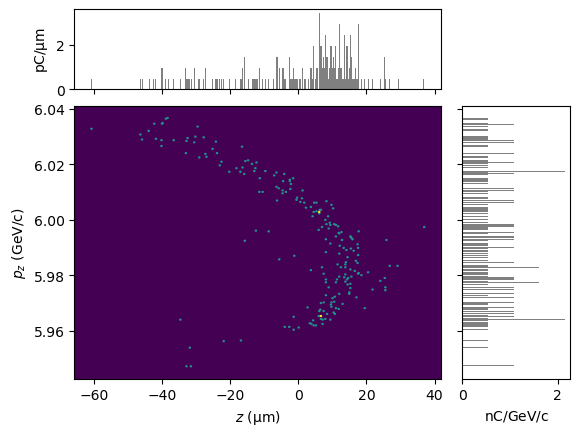

<Figure size 640x480 with 0 Axes>

In [12]:
trackBeam( tao, **importedDefaultSettings )
P = getBeamAtElement(tao, "PENT") 
display(plotMod(P, 'z', 'pz', bins=300))
plt.clf()

In [13]:
from scipy.optimize import minimize

def objective(params, tao, targetR56):

    overrides = {
            "Q1EkG" : params[0],
            "Q2EkG" : params[1],
            "Q3EkG" : params[2],
            "Q4EkG" : params[3],
            "Q5EkG" : params[4],
            "Q6EkG" : params[5],
            }

    #print(overrides)
    
    setLattice(
        tao,
        **(importedDefaultSettings | overrides)

    )

    #targetR56 = -9.8e-3

    newR56 = getMatrix(tao, "BEGBC20", "MFFF")[4][5]

    error = (targetR56 - newR56) ** 2

    #Optional: Prefer small changes to the quads
    changeCost = 1e-9 * np.linalg.norm( np.array( params ) - np.array( originalSettings ) ) ** 2
    error += changeCost

    return error

In [14]:
setLattice(tao, **importedDefaultSettings)

In [15]:
initialGuess = originalSettings

#For now, just hardcoding bounds... could generalize if required
#From "bounds.yml" as of 2025-06-18
# Q1EkGBounds :  (0, 388)  #BCON = 133
# Q2EkGBounds :  (-364, 0) #BCON = -136
# Q3EkGBounds :  (0, 299)  #BCON = 94
# Q4EkGBounds :  (0, 304)  #BCON = 118
# Q5EkGBounds :  (-117, 0) #BCON = -17
# Q6EkGBounds :  (-301, 0) #BCON = -142

bounds = [(0,388), (-364,0), (0, 299), (0, 304), (-117, 0), (-301, 0)]


# Perform optimization using Nelder-Mead
result = minimize(
    objective, 
    initialGuess, 
    method='Nelder-Mead',
    bounds = bounds,
    args = (tao, -9.8e-3)
)



print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")

Optimization Results:
Optimal Parameters: [ 96.76327749 -92.60555222  65.44005509  79.23571046 -14.09435886
 -85.37587361]
Objective Function Value at Optimal Parameters: 5.023103975800628e-10
Number of Iterations: 283
Converged: True


In [16]:
objective( result.x, tao, -9.8e-3 ) 

5.023103975800628e-10

In [17]:
getMatrix(tao, "BEGBC20", "MFFF", print = True);

-1.621739,-5.226112,-0.000000,-0.000000,0.000000,0.047606
-0.279008,-1.515736,0.000000,0.000000,0.000000,0.005071
-0.000000,-0.000000,-1.070892,-1.065764,0.000000,-0.000000
0.000000,0.000000,-0.099438,-1.032762,0.000000,0.000000
-0.005059,-0.045658,0.000000,0.000000,1.000000,-0.009800
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


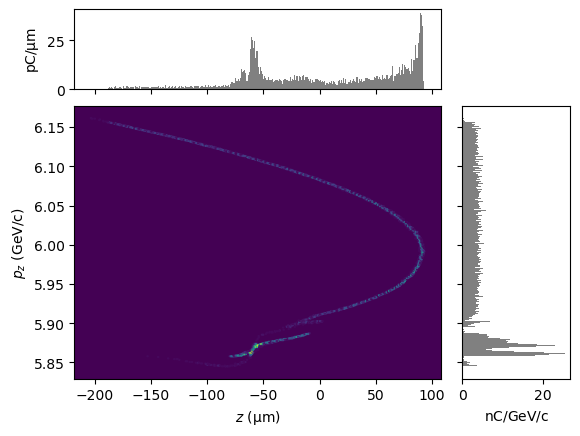

In [18]:
trackBeam( tao, **importedDefaultSettings )
P = getBeamAtElement(tao, "PENT") 
display(plotMod(P, 'z', 'pz', bins=300))
plt.clf()

-0.012
Optimization Results:
Optimal Parameters: [ 96.75304401 -92.64904403  65.02671874  79.16288521 -14.08290956
 -85.37814052]
Objective Function Value at Optimal Parameters: 1.2742110985654232e-09
Number of Iterations: 708
Converged: True


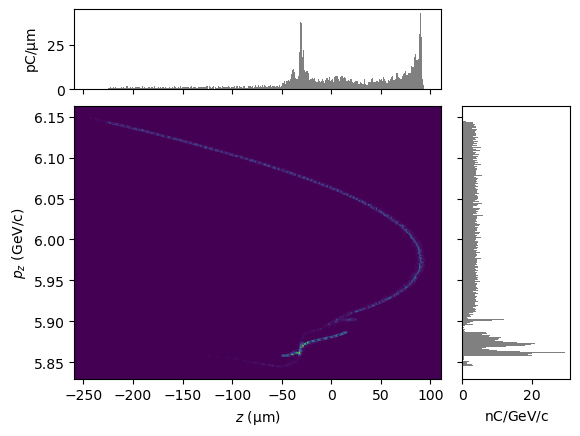

71.54409211967747
-0.01
Optimization Results:
Optimal Parameters: [ 96.76065082 -92.6100982   65.3986096   79.22723849 -14.06232894
 -85.37377048]
Objective Function Value at Optimal Parameters: 5.606504450412136e-10
Number of Iterations: 512
Converged: True


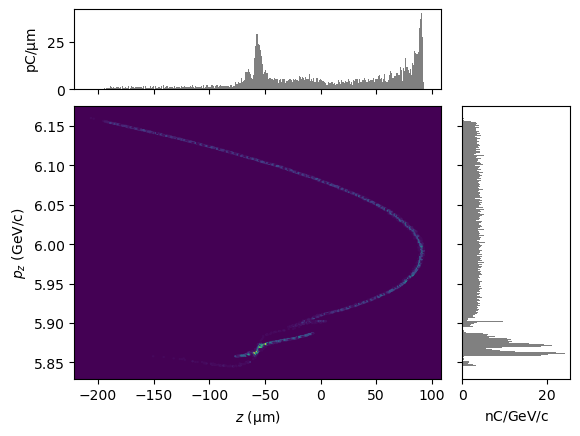

100.46070194958813
-0.008
Optimization Results:
Optimal Parameters: [ 96.77416331 -92.56678417  65.82847829  79.30476424 -14.03954304
 -85.36698364]
Objective Function Value at Optimal Parameters: 9.546605904303343e-11
Number of Iterations: 428
Converged: True


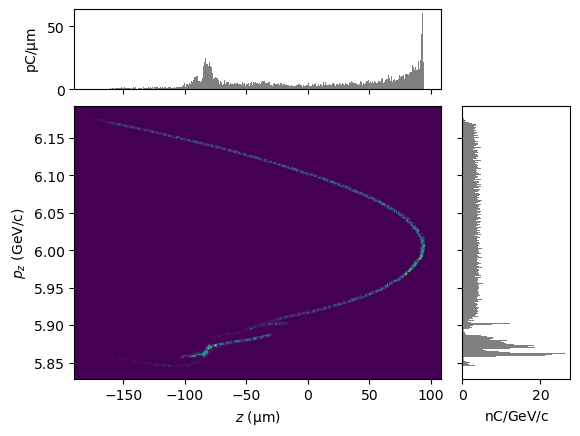

129.2572121283767
-0.006
Optimization Results:
Optimal Parameters: [ 96.79651349 -92.51620682  66.35732594  79.40356373 -14.01209176
 -85.35944374]
Objective Function Value at Optimal Parameters: 5.41130027254999e-11
Number of Iterations: 358
Converged: True


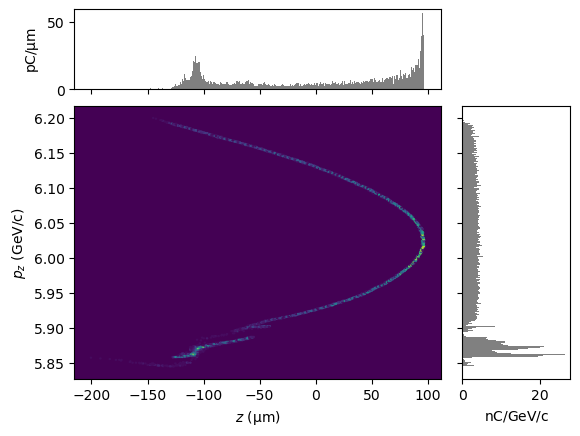

157.57700942901542
-0.004
Optimization Results:
Optimal Parameters: [ 97.29992278 -92.20389639  69.04537579  80.18504808 -13.80571652
 -85.33719899]
Objective Function Value at Optimal Parameters: 9.603455330624195e-09
Number of Iterations: 208
Converged: True


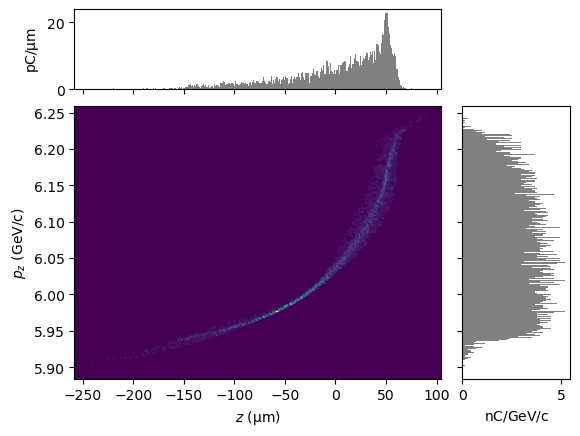

WARNING! Expected drive/witness structure not found


TypeError: cannot unpack non-iterable NoneType object

In [19]:
for targetR56 in np.arange( -12e-3, 0, 2e-3 ):
    
    print(targetR56) 
    
    result = minimize(
        objective, 
        initialGuess, 
        method='Nelder-Mead',
        bounds = bounds,
        args = (tao, targetR56)
    )


    print("Optimization Results:")
    print(f"Optimal Parameters: {result.x}")
    print(f"Objective Function Value at Optimal Parameters: {result.fun}")
    print(f"Number of Iterations: {result.nit}")
    print(f"Converged: {result.success}")


    objective( result.x, tao, targetR56 ) 

    trackBeam( tao, **importedDefaultSettings )
    P = getBeamAtElement(tao, "PENT") 
    display(plotMod(P, 'z', 'pz', bins=300))
    plt.clf()

    PDrive, PWitness = getDriverAndWitness(P)
    print( 1e6 * (np.median(PDrive.z) - np.median(PWitness.z)) ) 